# Good Vibes: The Probability of Earthquake Magnitude and Death
*A Milestone Report for the Introduction to Data Science Project*  
  
**Team Fugacity Members**  
Paul Mundt, u0932146  
Katie Jones, u0541901  

## Data Collection and Cleaning

The main source of data for the regressions comes from the Earthquake Impact Database on earthquake-report.com. For the analysis, we are analyzing data from 2017-2020. The data from 2020 is partial, and includes information that was availible on Wednesday, March 18th. 

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import scipy as sci
from requests import get
import folium
from geopy.geocoders import ArcGIS
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (12, 12) 

In [2]:
# Import CSV Files Extracted from the Earthquake Impact Database
data_2017 = pd.read_csv("2017_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all")
data_2018 = pd.read_csv("2018_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all")
data_2019 = pd.read_csv("2019_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all")
data_2020 = pd.read_csv("2020_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all", thresh = 2)

In [3]:
#Clean 2020 Data
data_2020 = data_2020.drop('Depth (km)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2020 = data_2020.fillna(value = 0)
data_2020 = data_2020.rename(columns = {"Epicenter" : "Country", "Region (Epicenter)" : "Region"} )

#Clean 2019 Data
data_2019 = data_2019.drop('Depth (km)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2019 = data_2019.fillna(value = 0).replace("--", "0")
data_2019 = data_2019.rename(columns = {"Country (Epicenter)" : "Country", "Region (Epicenter)" : "Region"} )

#Clean 2018 Data
data_2018 = data_2018.drop('Depth (km)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2018 = data_2018.fillna(value = 0).replace("--", "0")
latlong_2018 = [0 for _ in range(0, len(data_2018.index))]
data_2018.insert(loc = 4, column = 'Lat', value = latlong_2018)
data_2018.insert(loc = 5, column = 'Long', value = latlong_2018)
data_2018 = data_2018.rename(columns = {"Country (Epicenter)" : "Country", "Region (Epicenter)" : "Region"} )

#Clean 2017 Data
data_2017 = data_2017.drop('Depth (km)', axis = 1).drop('Tsunami height', axis = 1)
data_2017 = data_2017.fillna(value = 0).replace("--", "0")
latlong_2017 = [0 for _ in range(0, len(data_2017.index))]
data_2017.insert(loc = 4, column = 'Lat', value = latlong_2017)
data_2017.insert(loc = 5, column = 'Long', value = latlong_2017)
data_2017 = data_2017.rename(columns = {"Impact coefficient (D)" : "Impact value (D)"} )

In [4]:
#Concatenate Dataframes into a Single Dataset
earthquake_data = pd.concat([data_2017, data_2018, data_2019, data_2020], sort = False).reset_index(drop = True)

In [5]:
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('+',' ')
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('-',' ')
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('JMA',' ')
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('/ 7',' ')
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('Shindo ','')

def roman_to_number(num):
    rom_val = {'I': 1, 'V': 5, 'X': 10, 'L':50 , 'C':100, 'D':500, 'M':1000}
    res=0
    i=0
    while i<len(num):
        s1=num[i]
        num1=rom_val[s1]
        if i+1<len(num):
            s2=num[i+1]
            num2=rom_val[s2]
            if num2<=num1:
                res=res+num1
                i+=1
            else:
                res=res+num2-num1
                i+=2
        else:
            res=res+num1
            i+=1
    return(res)
        
    
           
def change(num):
    if type(num)==str:
        if len(num)>4:
            tip=num[0:len(num)//2].strip()
        else:
            tip=num.strip()
        try:
            return(int(tip))
        except:
            return(roman_to_number(tip))
    else:
        return(num)
earthquake_data['Intensity (MMI / JMA)']=[change(chest) for chest in earthquake_data['Intensity (MMI / JMA)']]

In [6]:
earthquake_data

,Date (UTC),Country,Region,Magnitude,Lat,Long,Intensity (MMI / JMA),Fatalities,Injuries,displaced,Impact value (D),buildings damaged,buildings destroyed
0,1/2/2017,Italy,Umbria,4.1,0.00,0.00,5.0,0.0,0.0,30.0,0.194401,0.0,0.0
1,1/3/2017,India,Tripura,5.5,0.00,0.00,NaN,3.0,49.0,600.0,1.668774,1456.0,166.0
2,1/3/2017,Brazil,Maranhao,4.6,0.00,0.00,NaN,0.0,0.0,0.0,0.752967,500.0,0.0
3,1/3/2017,Fiji,Western Division (OS),7.2,0.00,0.00,4.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,1/6/2017,Iran,Fars,5.1,0.00,0.00,NaN,4.0,4.0,905.0,1.447852,400.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,3/13/2020,India,Kerala,2.8,9.79,76.88,NaN,0.0,0.0,0.0,0.038254,10.0,0.0
978,3/13/2020,Tanzania,Tanga,4.8,-4.90,38.55,NaN,0.0,0.0,0.0,0.007925,2.0,0.0
979,3/14/2020,Iran,Qom,4.0,34.56,50.72,NaN,0.0,0.0,0.0,0.038254,10.0,0.0
980,3/15/2020,Iran,Hormozgan,5.4,27.20,55.32,NaN,0.0,2.0,0.0,0.235972,20.0,1.0


We are also able to get the current earthquake data from the USGS website and apply it to a webmap, with pop-ups. These pop-ups will hold future information for probability and other needed info.

In [7]:
url = 'http://feed.unmung.com/feed?feed=http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/4.5+_month.atom'
response=get(url)
soup=BeautifulSoup(response.text,'html.parser')

Location=soup.find_all('a',class_="u-url")
Data=soup.find_all('span',class_="e-summary")
Location.pop(0)
def mag_title(x):
    magnitude=float(x[1:5])
    location=x[7:]
    return(magnitude,location)

Locate=[]
magni=[]
for kip in Location:
    inter=kip.get_text()
    poper=mag_title(inter)
    Locate.append(poper[1])
    magni.append(poper[0])

In [8]:
time=[]
loc=[]
depth=[]
for stuff in Data:
    j=stuff.find_all('dd')
    time.append(j[0].get_text())
    loc.append(j[2].get_text())
    depth.append(j[3].get_text())   

def lattitudel(x):
    if "S" in x:
        cord=-float(x.replace('°S',''))
    else:
        cord=float(x.replace('°N',''))
    return(cord)

def longitudel(x):
    if "W" in x:
        cord=-float(x.replace('°W',''))
    else:
        cord=float(x.replace('°E',''))
    return(cord)
def coord_split(x):
    half=len(x)//2
    first=x[:half]
    last=x[half:]
    return(first,last)

lattitude=[]
longitude=[]
for sets in loc:
    x,y=coord_split(sets)
    lattitude.append(lattitudel(x))
    longitude.append(longitudel(y))

Current=pd.DataFrame(zip(time,Locate,magni,depth,lattitude,longitude), columns=['time','Location','Magnitude','Depth (km)','lattitude','longitude'])
Current

,time,Location,Magnitude,Depth (km),lattitude,longitude
0,2020-04-02 18:43:38 UTC,"58km N of Visokoi Island, South Georgia and t...",5.1,64.40 km (40.02 mi),-56.178,-27.316
1,2020-04-02 10:15:41 UTC,"144km SW of Jiquilillo, Nicaragua",5.2,49.31 km (30.64 mi),11.804,-88.366
2,2020-04-02 10:08:34 UTC,"13km ENE of Hirara, Japan",4.7,44.13 km (27.42 mi),24.863,125.396
3,2020-04-02 09:13:17 UTC,"193km E of Hachinohe, Japan",4.5,10.00 km (6.21 mi),40.706,143.765
4,2020-04-02 03:38:30 UTC,"152km NW of Sola, Vanuatu",4.7,151.01 km (93.83 mi),-12.905,166.563
...,...,...,...,...,...,...
376,2020-03-04 04:23:20 UTC,"28km ENE of L'Esperance Rock, New Zealand",4.5,10.00 km (6.21 mi),-31.369,-178.613
377,2020-03-04 03:41:20 UTC,"216km SE of Lambasa, Fiji",4.5,567.00 km (352.32 mi),-17.594,-178.998
378,2020-03-04 02:52:17 UTC,"69km WSW of Port-Vila, Vanuatu",4.5,10.00 km (6.21 mi),-17.996,167.725
379,2020-03-04 00:20:03 UTC,"116km W of Bhamo, Burma",4.8,10.00 km (6.21 mi),24.420,96.102


We also took into account the gdp of each country as compared to its population to get the following:

In [9]:
url = 'https://www.worldometers.info/gdp/gdp-by-country/'
response=get(url)
soup=BeautifulSoup(response.text,'html.parser')
Head=soup.find('thead')
H=Head.find_all('th')
Table=soup.find('tbody')
T=Table.find_all('tr')
columns=[col for col in T[0]]
Beep=[T[i] for i in range(0,len(T))]
headers=[i.get_text() for i in H]

tipping=[]
for col in columns:
    if col==' ':
        pass
    else:
        tipping.append(col.get_text())
tip=[]
for i in range(0,len(T)):
    clip=[]
    columns=[col for col in T[i]]
    for col in columns:
        if col==' ':
            pass
        else:
            clip.append(col.get_text())
    tip.append(clip)
gdp=pd.DataFrame(tip,columns=headers)

#cleaning GDP nominal
gdp['GDP (nominal, 2017) ']=gdp['GDP (nominal, 2017) '].str.replace('$',' ')
gdp['GDP (nominal, 2017) ']=gdp['GDP (nominal, 2017) '].str.replace(',','').astype(float)
gdp['GDP (nominal, 2017) ']=pd.to_numeric(gdp['GDP (nominal, 2017) '] )
gdp.rename(columns={'GDP (nominal, 2017) ':'GDP($)'}, inplace=True)

#Cleanng GDP abbrev
gdp['GDP (abbrev.)']=gdp['GDP (abbrev.)'].str.replace('$',' ')
def money(num,part):
    if part=='trillion':
        num=num*1000000000000
    elif part=='billion':
        num=num*1000000000
    else:
        num=num*1000000
    return(num)

def marker(plop):
    mak=len(plop)//2
    num=plop[0:mak]
    word=plop[mak:len(plop)]
    if word=='illion' or word=='rillion' :
        num=float(plop[0:mak-1])
        word=plop[mak-1:len(plop)]
        return(money(num,word))
    else:
        return(money(float(num),word))
gdp['GDP (abbrev.)']=[marker(i) for i in gdp['GDP (abbrev.)']]
gdp.rename(columns={'GDP (abbrev.)':'GDP (abbrev.)($)'}, inplace=True)

#clean growth
gdp['GDP  growth']=gdp['GDP  growth'].str.replace('%','').astype(float).divide(100)
gdp.rename(columns={'GDP  growth':'GDP  growth(%)'}, inplace=True)
#clean population
gdp['Population (2017) ']=gdp['Population (2017) '].str.replace(',','').astype(int)
gdp.rename(columns={'Population (2017) ':'Population'}, inplace=True)
#clean per capita
gdp['GDP  per capita ']=gdp['GDP  per capita '].str.replace('$',' ').str.replace(',','').astype(int)
gdp.rename(columns={'GDP  per capita ':'GDP  per capita ($)'}, inplace=True)
#share of GDP
gdp['Share of World GDP ']=gdp['Share of World GDP '].str.replace('%','').astype(float).divide(100)
gdp.rename(columns={'Share of World GDP ':'Share of World GDP (%)'}, inplace=True)

gdp

,#,Country,GDP($),GDP (abbrev.)($),GDP growth(%),Population,GDP per capita ($),Share of World GDP (%)
0,1,United States,1.948539e+13,1.948500e+13,0.0227,325084756,59939,0.2408
1,2,China,1.223770e+13,1.223800e+13,0.0690,1421021791,8612,0.1512
2,3,Japan,4.872415e+12,4.872000e+12,0.0171,127502725,38214,0.0602
3,4,Germany,3.693204e+12,3.693000e+12,0.0222,82658409,44680,0.0456
4,5,India,2.650725e+12,2.651000e+12,0.0668,1338676785,1980,0.0328
...,...,...,...,...,...,...,...,...
184,185,Sao Tome & Principe,3.925703e+08,3.930000e+08,0.0387,207089,1896,0.0000
185,186,Palau,2.898235e+08,2.900000e+08,-0.0357,17808,16275,0.0000
186,187,Marshall Islands,2.041734e+08,2.040000e+08,0.0360,58058,3517,0.0000
187,188,Kiribati,1.855725e+08,1.860000e+08,0.0033,114158,1626,0.0000


We are hoping as of right now that this will help us to determine some correlation between earthquakes and damage. The hope is to see a correlation between countries with higher gdps having less damage than those of lower gdp.
<br>
At some point we hope to be able to attach cities to some of the cordinates and see if we can get a good cluster of points to determine how often earthquakes strick at certain magnitudes and what damaged is caused from them.

## Data Exploration

Exploring the data through graphs before applying an analysis.
$$
$$
First thing we wanted to do was to take our USGS data and apply it to a geomap to see if we could see a pattern of where earthquakes are more likley to happen. This is important especially when we look at regresion and clustering analysis. Since our 2017-2018 data has no longitude or lattitude points. We will procede with 2019-2020 data for cluster analysis.

In [10]:
def cool(m):
    if 0<=m<1:
        return('green')
    elif 1<=m<2:
        return('orange')
    elif 2<=m<3:
        return('blue')
    elif 3<=m<4:
        return('teal')
    elif 5<=m<6:
        return('purple')
    elif 6<=m<7:
        return('amber')
    else:
        return('red')
    
nom=ArcGIS()
p=nom.geocode("Palais du Gouvernement,P.O. Box 4546,N'Djaména")
map=folium.Map(location=[p.latitude,p.longitude], zoom_start=2, tiles="Stamen Terrain")

html="""<h4><b>Earquakes Info</b></h4>
<p><b>Location: </b>%s</p>
<p><b>Magnitude: </b>%s</p>"""
fgv=folium.FeatureGroup(name="shake")
for la, lo, m,l in zip(lattitude,longitude,magni,Locate):
    iframe=folium.IFrame(html=html %(l,str(m)),width=200,height=100)
    fgv.add_child(folium.CircleMarker(location=[la,lo],fill_color=cool(m),popup=folium.Popup(iframe),fill=True,color='black',fill_capacity=0.9))
map.add_child(fgv)

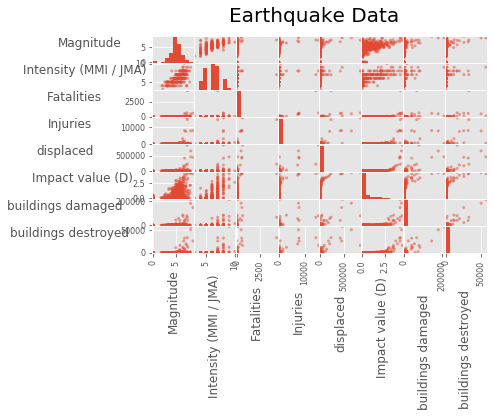

In [11]:
col=['Magnitude','Intensity (MMI / JMA)','Fatalities','Injuries','displaced','Impact value (D)','buildings damaged','buildings destroyed']
scattering=earthquake_data[col]
axs=pd.plotting.scatter_matrix(scattering)
plt.suptitle('Earthquake Data', size=20)
n = len(scattering.columns)
for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = axs[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50

We noticed several things about the data.  

First of all, the data points with a magnitude of zero could skew any analysis, since they indicate impact without an earthquake occuring.  
Second, many of the distributions seem to follow nonlinear and bell-like relationships. This makes us believe there is a factor(s) other than magnitude that affect the relationships. Additionally, the logrithmic behavior of magnitude might be affecting the linearity of the relationship. 

When we dive deeper into the earthquake data we find the following:

In [12]:
earthquake_data.groupby(['Country']).count()

,Date (UTC),Region,Magnitude,Lat,Long,Intensity (MMI / JMA),Fatalities,Injuries,displaced,Impact value (D),buildings damaged,buildings destroyed
Country,,,,,,,,,,,,
0,22,22,22,22,22,1,22,22,22,22,22,22
Afghanistan,5,5,5,5,5,1,5,5,5,5,5,5
Albania,12,12,12,12,12,3,12,12,12,12,12,12
Algeria,4,4,4,4,4,1,4,4,4,4,4,4
Angola,1,1,1,1,1,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
United Kingdom,4,4,4,4,4,4,4,4,4,4,4,4
Vanuatu,3,3,3,3,3,1,3,3,3,3,3,3
Venezuela,18,18,18,18,18,4,18,18,18,18,18,18


In [13]:
earthquake_data.groupby(['Intensity (MMI / JMA)']).describe()

Magnitude                                              \
                          count      mean       std  min    25%  50%    75%   
Intensity (MMI / JMA)                                                         
3.0                         1.0  2.100000       NaN  2.1  2.100  2.1  2.100   
4.0                        24.0  4.033333  1.446635  1.9  3.075  3.7  4.725   
5.0                        60.0  4.665000  1.118992  2.5  4.000  4.5  5.300   
6.0                        71.0  5.478873  0.779911  3.8  4.950  5.4  6.000   
7.0                        65.0  6.015385  0.629045  4.8  5.500  6.0  6.500   
8.0                        30.0  6.456667  0.781988  4.0  6.150  6.5  6.875   
9.0                         5.0  7.120000  0.708520  6.4  6.500  7.1  7.500   
10.0                        1.0  6.700000       NaN  6.7  6.700  6.7  6.700   

                             Lat                ... buildings damaged  \
                       max count          mean  ...               75%   
Intensity (MMI / JMA)                           ...                     
3.0                    2.1   1.0  53787.000000  ...              1.00   
4.0                    7.3  24.0      8.531667  ...             11.50   
5.0                    7.9  60.0   3631.717167  ...              7.75   
6.0                    7.5  71.0   1066.986099  ...            224.50   
7.0                    7.4  65.0    637.120769  ...           2155.00   
8.0                    7.9  30.0   -993.114633  ...           5973.25   
9.0                    8.1   5.0   7153.200000  ...          73671.00   
10.0                   6.7   1.0      0.000000  ...          15026.00   

                                buildings destroyed                \
                            max               count          mean   
Intensity (MMI / JMA)                                               
3.0                         1.0                 1.0      0.000000   
4.0                      4832.0                24.0      0.000000   
5.0                       958.0                60.0      0.066667   
6.0                     57629.0                71.0     53.295775   
7.0                     66207.0                65.0   1637.769231   
8.0                     83745.0                30.0   4041.933333   
9.0                    211497.0                 5.0  14206.200000   
10.0                    15026.0                 1.0   2032.000000   

                                                                        \
                                std     min      25%     50%       75%   
Intensity (MMI / JMA)                                                    
3.0                             NaN     0.0     0.00     0.0      0.00   
4.0                        0.000000     0.0     0.00     0.0      0.00   
5.0                        0.516398     0.0     0.00     0.0      0.00   
6.0                      167.041774     0.0     0.00     0.0      6.50   
7.0                     5395.494419     0.0     0.00    28.0    459.00   
8.0                     7625.701794     0.0   124.75   471.5   1941.25   
9.0                    24695.476462    39.0    41.00  1680.0  11761.00   
10.0                            NaN  2032.0  2032.00  2032.0   2032.00   

                                
                           max  
Intensity (MMI / JMA)           
3.0                        0.0  
4.0                        0.0  
5.0                        4.0  
6.0                      906.0  
7.0                    32979.0  
8.0                    32016.0  
9.0                    57510.0  
10.0                    2032.0  

[8 rows x 72 columns]

As we look more into the data we find that there are some patternsto be discovered. For example, we can see that over the course of 4 years, certain countries get hit harder than others with earthquakes. We will have to go into that deeper for this project and see which places we can focus our attention on.
<br>
When we look at intensity, we see a and expected a rise in magnitude with intensity as well as with everythng else. However, it can be noted that at intensity 9 we get a higher magnitude than intensity 10. We also see what intensities happen the most as well with 6 having the most compared to anyone else.

## Final Analysis and Deviation
**Final analysis:** We will havesome work to do on looking though our numbers and seeing the best corelations. This may include looking into the most hit places and seeing if we can find anything there. Our database data has been cleaned and is now easier to read, but with what we have scraped, we need to bring together and possiblly find a better corrolation there.
$$
$$
**Deviation:** There was going to be a lot more data that we wanted to include. This came with the possibility of looking at 10 different cities and comparing population density, building grades, infrastructure, response/warning systems, and much more. However, this data has turned out to be a lot harder to find for any place. The amount of time it would take to find and scrape all of that data is not conducive with our time frame.
$$
$$
**Peer Review Feedback:** We got feed back from Amber Kiser. During the peer review, we mostly discussed the most effective ways to determine and quanitify infrastruture for a given location. We discussed using infrastructure spending or some type of rating system. Additionally, she wondered about the types of regressions we would be running. We discussed the use of doing a strict linear, multi-variable regression in comparison with a nonlinear variation. We figured we would just have to play around with the data. Additionally, she agreed that exploring whether clustering affected the accuracy of the regressions was a good thing to explore.